# SRCNN - TensorFlow

@rajeev

* Utilities
* Build Model
* Download CIFAR 10 image data and pre-process 
* Compile Model
    * Setup Tensorboard callback
    * Setup Checkpoints callback
* Train the model
* Evaluate accuracy
* Inference
* View weights and bias

In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

2.3.0


## Utilities

In [2]:
def compute_psnr(gold, test):
    diff = gold.astype('float') - test.astype('float')
    diff = diff ** 2.0
    diff = diff.flatten('C')
    denom = np.sqrt(np.mean(diff))
    return 20 * np.log10(255.0 / denom)

def compute_psnr_keras(gold, test):
    denom = tf.keras.backend.mean( tf.keras.backend.square(gold - test) )
    return 20* tf.keras.backend.log(255.0 /denom)

In [3]:
def blur_half_downscale(image):
    t0 = cv2.GaussianBlur(image, ksize=(5, 5), sigmaX=0.7)
    t1 = t0[::2, ::2, :]
    return t1

In [4]:
def bilinterp_upscale(image, scale):
    m, n, c = image.shape

    f = (1./scale) * np.convolve(np.ones((scale, )), np.ones((scale, )))
    f = np.expand_dims(f, axis=0) # Making it (1, (2*scale)-1)-shaped
    filt = f.T * f
    print(filt)
    print(filt.shape)
    print(f)
    new_image = np.zeros((m*scale, n*scale, c))
    new_image[::scale, ::scale, :] = image
    new_image = cv2.filter2D(new_image, -1, filt)
    return new_image

In [5]:
im0 = cv2.imread('./dataset/Test/Set14/baboon.bmp')[..., ::-1].astype(float)
#im1 = im0
im1 = blur_half_downscale(im0)
im1 = blur_half_downscale(im1)
im1 = cv2.cvtColor(im1.astype(np.uint8), cv2.COLOR_BGR2RGB)
cv2.imwrite("baboon_down4.bmp", im1)

True

In [6]:
# upscale by 4x using bilinear interpolation and check the PSNR
im2 = bilinterp_upscale(im1, scale=4)
cv2.imwrite("baboon_bilinear_up4.bmp", im2)

[[0.0625 0.125  0.1875 0.25   0.1875 0.125  0.0625]
 [0.125  0.25   0.375  0.5    0.375  0.25   0.125 ]
 [0.1875 0.375  0.5625 0.75   0.5625 0.375  0.1875]
 [0.25   0.5    0.75   1.     0.75   0.5    0.25  ]
 [0.1875 0.375  0.5625 0.75   0.5625 0.375  0.1875]
 [0.125  0.25   0.375  0.5    0.375  0.25   0.125 ]
 [0.0625 0.125  0.1875 0.25   0.1875 0.125  0.0625]]
(7, 7)
[[0.25 0.5  0.75 1.   0.75 0.5  0.25]]


True

In [7]:
print("im0.shape : ", im0.shape)
print("im1.shape : ", im1.shape)
print("im2.shape : ", im2.shape)
print("PSNR : im0 <-> im2 : ", compute_psnr(im0, im2) ) # expect ~10
print("PSNR : im0 <-> im2 : ", compute_psnr_keras(im0, im2) ) # expect ~10

im0.shape :  (480, 500, 3)
im1.shape :  (120, 125, 3)
im2.shape :  (480, 500, 3)
PSNR : im0 <-> im2 :  10.476805787439023
PSNR : im0 <-> im2 :  tf.Tensor(-62.577797246466844, shape=(), dtype=float64)


## Data pre-process

In [ ]:
def train_data_preprocess(scale=3, path="./dataset/Train/" ):
    """ https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
    """
    patch_size = 33
    scale = 3
    stride = 14
    g = 6 # guard on either side = 33-21/2 = 6
    
    names = os.listdir(path)
    names = sorted(names)
    nums = names.__len__()

    print("nums : ", nums)
    #print("names : ", names)
    
    X_train, Y_train = [], []
        
    for i in range(nums):
        name = path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[0:hr_img.shape[0]-np.remainder(hr_img.shape[0],scale),
                        0:hr_img.shape[1]-np.remainder(hr_img.shape[1],scale), 
                        0]
        
        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, None, fx=1/scale, fy=1/scale, interpolation = cv2.INTER_CUBIC)
        lr_img = cv2.resize(lr_img, None, fx=scale,   fy=scale,   interpolation = cv2.INTER_CUBIC)
        v, h = hr_img.shape
        
        
        if True: # ordered
            for x in range(0, v - patch_size, stride):
                for y in range(0, h - patch_size,stride):
                    lr_patch = lr_img[x    : x + patch_size,     y     : y + patch_size].astype('double') / 255.0
                    hr_patch = hr_img[x + g: x + patch_size - g, y + g : y + patch_size - g].astype('double') / 255.0

                    X_train.append(lr_patch)
                    Y_train.append(hr_patch)
        else: # random
            num_patches = 100
            x = np.random.randint(0, hr_img.shape[0] - patch_size, num_patches)
            y = np.random.randint(0, hr_img.shape[1] - patch_size, num_patches)
            for n in range(num_patches):
                lr_patch = lr_img[x[n] : x[n] + patch_size, y[n] : y[n] + patch_size].astype('double') / 255.0
                hr_patch = hr_img[x[n] : x[n] + patch_size, y[n] : y[n] + patch_size].astype('double') / 255.0
                
                X_train.append(lr_patch)
                Y_train.append(hr_patch)
                
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return X_train, Y_train


In [ ]:
#X_train, Y_train = load_train(image_size=32, stride=14, scale=3)
scale=3
X_train, Y_train = train_data_preprocess(scale, path="./dataset/Train/")
X_val, Y_val     = train_data_preprocess(scale, path="./dataset/Test/Set5/")

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

In [ ]:
idx = 37
plt.imshow(X_train[idx])

In [ ]:
plt.imshow(Y_train[idx])

## Build Model

In [9]:
def create_model(learningRate=0.0003, hiddenSize=1, dim=33, modelName='srcnn'): 
    # input data dimension is 33
    # label dimension is 21

    inputs = tf.keras.Input(shape=(dim,dim,1))
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=9, padding='valid', activation='relu')(inputs)
    # input  shape: 33, 33, 1
    # output shape: 25, 25, 64
    # parameters: weights=(9*9*3)*64 , biases=64

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=hiddenSize, padding='same', activation='relu')(x)
    # input  shape: 33, 3, 64
    # output shape: 25, 25, 32
    # parameters: weights=(1*1*64)*32 , biases=32

    outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=5, padding='valid')(x)
    # input  shape: 25, 25, 32
    # output shape: 21, 21, 1
    # parameters: weights=(1*1*64)*32 , biases=32

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=modelName)

    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=learningRate),
                  loss=tf.keras.losses.MeanSquaredError(),
                  #metrics=[compute_psnr_keras],
                  metrics=['mse'])
    return model

model = create_model(learningRate=0.0001, hiddenSize=1, dim=33, modelName='srcnn_train')
model.summary()

Model: "srcnn_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 33, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 64)        5248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


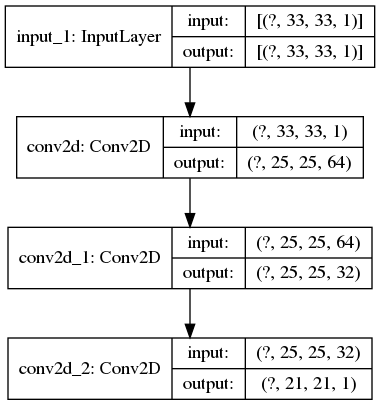

In [10]:
tf.keras.utils.plot_model(model, "srcnn_model.png", show_shapes=True)

## Train Model

### Setup callbacks

In [11]:
import tensorboard
import os
from datetime import datetime
print(tensorboard.__version__)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, 
                                                      write_images=True, 
                                                      histogram_freq=1,
                                                     )
# save checkpoints
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.save("/tmp/model")

2.3.0
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/model/assets


In [ ]:
#model.load_weights(os.path.join('./','srcnn_915_lr0.0001_epochs200-300.h5') )
model.fit(X_train, Y_train, epochs=20, batch_size=128, 
          callbacks=[tensorboard_callback, cp_callback],
          shuffle=True,
          validation_data=(X_val, Y_val),
          verbose=1
         )
model.save_weights('srcnn_915.h5')

## Test Model

In [12]:
model_test = create_model(learningRate=0.0001, hiddenSize=1, dim=None, modelName='srcnn_test')
model_test.load_weights(os.path.join('./metric_mse','srcnn_915_lr0.0001_epochs300-400.h5') )

In [13]:
def test_data_preprocess(scale=3, dirname = "./dataset/Test/Set14c/" ):
    dir_list = os.listdir(dirname)
    psnr_bicubic, psnr_srcnn, psnr_delta = [], [], []
    for f in dir_list:
        fileName = f.split(".")[0]
        
        if False: # black n white
            img = cv2.cvtColor(cv2.imread(os.path.join(dirname,f)),cv2.COLOR_BGR2GRAY)
            img = img[0:img.shape[0]-np.remainder(img.shape[0],scale),
                      0:img.shape[1]-np.remainder(img.shape[1],scale), :]
            downscaled = cv2.resize(img, None, fx=1/scale, fy=1/scale, interpolation=cv2.INTER_LINEAR) 

            upscaled   = cv2.resize(downscaled, None, fx=scale/1, fy=scale/1, interpolation=cv2.INTER_LINEAR) 
            cv2.imwrite("./result/"+fileName+"_bw_bicubic.jpg", upscaled)

            predicted = model_test.predict( upscaled.reshape(1,upscaled.shape[0],upscaled.shape[1],1))*255.0
            cv2.imwrite("./result/"+fileName+"_bw_srcnn.jpg", predicted[0,:, :, 0])
        
            psnrBicubic = compute_psnr(img, upscaled)
            psnrSrcnn   = compute_psnr(img, predicted)
            psnrDelta   = psnrSrcnn - psnrBicubic
            psnr_bicubic.append(psnrBicubic)
            psnr_srcnn.append(psnrSrcnn)
            psnr_delta.append(psnrDelta)
            #print("RGB:%s - bicubic:%f  srcnn:%f  delta:%f"%(f, psnr_bicubic, psnr_srcnn, psnr_delta))
            
        else: # color
            orig_img = cv2.cvtColor(cv2.imread(os.path.join(dirname,f)),cv2.COLOR_BGR2YCrCb)
            orig_img = orig_img[0:orig_img.shape[0]-np.remainder(orig_img.shape[0],scale),
                                0:orig_img.shape[1]-np.remainder(orig_img.shape[1],scale), :]
            
            downscaled = cv2.resize(orig_img, None, fx=1/scale, fy=1/scale, interpolation=cv2.INTER_CUBIC) 
            upscaled   = cv2.resize(downscaled, None, fx=scale/1, fy=scale/1, interpolation=cv2.INTER_CUBIC) 
            
            im = cv2.cvtColor(upscaled, cv2.COLOR_YCrCb2BGR)
            cv2.imwrite("./result/"+fileName+"_bicubic.jpg", im)
            
            img = upscaled
            for i in range(1):
                ifm = upscaled[:,:,i].astype(float)/255.0
                predicted = model_test.predict( ifm.reshape(1,ifm.shape[0],ifm.shape[1],1)) * 255.0
                predicted[predicted[:] > 255] = 255
                predicted[predicted[:] < 0] = 0
                img[6:-6,6:-6,i] = predicted[0,:, :, 0].astype(np.uint8)

            img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
            cv2.imwrite("./result/"+fileName+"_srcnn.jpg", img)
        
            im_orig    = cv2.imread(os.path.join(dirname,f), cv2.IMREAD_COLOR)
            im_orig    = cv2.cvtColor(im_orig, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
            im_bicubic = cv2.imread("./result/"+fileName+"_bicubic.jpg", cv2.IMREAD_COLOR)
            im_bicubic = cv2.cvtColor(im_bicubic, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
            im_srcnn   = cv2.imread("./result/"+fileName+"_srcnn.jpg", cv2.IMREAD_COLOR)
            im_srcnn   = cv2.cvtColor(im_srcnn, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
            im_orig = im_orig[:im_bicubic.shape[0], :im_bicubic.shape[1]]
                
            psnrBicubic = compute_psnr(im_orig, im_bicubic)
            psnrSrcnn   = compute_psnr(im_orig, im_srcnn)
            psnrDelta   = psnrSrcnn - psnrBicubic
            psnr_bicubic.append(psnrBicubic)
            psnr_srcnn.append(psnrSrcnn)
            psnr_delta.append(psnrDelta)
            #print("RGB:%s - bicubic:%f  srcnn:%f  delta:%f"%(f, psnr_bicubic, psnr_srcnn, psnr_delta))    
            
    return psnr_bicubic, psnr_srcnn, psnr_delta

print("---------train set---------")
psnr_bicubic, psnr_srcnn, psnr_delta = test_data_preprocess(scale=3, dirname = "./dataset/Train/" )
print("SRCNN: [%f, %f]  BiCubic: [%f, %f]  Delta: [%f, %f]"%(min(psnr_srcnn), max(psnr_srcnn), min(psnr_bicubic), max(psnr_bicubic), min(psnr_delta), max(psnr_delta) ))
print("---------val set---------")
psnr_bicubic, psnr_srcnn, psnr_delta = test_data_preprocess(scale=3, dirname = "./dataset/Test/Set5/" )
print("SRCNN: [%f, %f]  BiCubic: [%f, %f]  Delta: [%f, %f]"%(min(psnr_srcnn), max(psnr_srcnn), min(psnr_bicubic), max(psnr_bicubic), min(psnr_delta), max(psnr_delta) ))
print("---------test set---------")
psnr_bicubic, psnr_srcnn, psnr_delta = test_data_preprocess(scale=3, dirname = "./dataset/Test/Set14/" )
print("SRCNN: [%f, %f]  BiCubic: [%f, %f]  Delta: [%f, %f]"%(min(psnr_srcnn), max(psnr_srcnn), min(psnr_bicubic), max(psnr_bicubic), min(psnr_delta), max(psnr_delta) ))
print("---------test set 1---------")
psnr_bicubic, psnr_srcnn, psnr_delta = test_data_preprocess(scale=3, dirname = "./dataset/Test/Set14c/" )
print("SRCNN: [%f, %f]  BiCubic: [%f, %f]  Delta: [%f, %f]"%(min(psnr_srcnn), max(psnr_srcnn), min(psnr_bicubic), max(psnr_bicubic), min(psnr_delta), max(psnr_delta) ))


---------train set---------
SRCNN: [18.158525, 39.649426]  BiCubic: [17.471841, 39.040397]  Delta: [-0.734563, 2.876044]
---------val set---------
SRCNN: [23.483245, 31.937008]  BiCubic: [21.997897, 31.653675]  Delta: [0.283332, 1.485349]
---------test set---------
SRCNN: [20.679276, 31.298937]  BiCubic: [20.091308, 30.100724]  Delta: [0.175172, 1.661073]
---------test set 1---------
SRCNN: [25.415441, 25.729739]  BiCubic: [24.912500, 25.701384]  Delta: [0.028355, 0.502941]


In [14]:
model.summary()
model.layers

Model: "srcnn_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33, 33, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 64)        5248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 1)         801       
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
_________________________________________________________________


In [15]:
for i in [1, 2, 3]:
    weights, biases = model.layers[i].get_weights()
    print(weights.shape, biases.shape)


(9, 9, 1, 64) (64,)
(1, 1, 64, 32) (32,)
(5, 5, 32, 1) (1,)


* epochs = 400 - metric = mse

* ---------train set---------
* SRCNN: [18.158525, 39.649426]  BiCubic: [17.471841, 39.040397]  Delta: [-0.734563, 2.876044]
* ---------val set---------
* SRCNN: [23.483245, 31.937008]  BiCubic: [21.997897, 31.653675]  Delta: [0.283332, 1.485349]
* ---------test set---------
* SRCNN: [20.679276, 31.298937]  BiCubic: [20.091308, 30.100724]  Delta: [0.175172, 1.661073]
* ---------test set 1---------
* SRCNN: [25.415441, 25.729739]  BiCubic: [24.912500, 25.701384]  Delta: [0.028355, 0.502941]


* epochs = 20 - metrics = compute_psnr_loss
* ---------train set---------
* SRCNN: [17.985869, 38.975022]  BiCubic: [17.471841, 39.040397]  Delta: [-0.722757, 1.639919]
* ---------val set---------
* SRCNN: [22.975835, 31.852388]  BiCubic: [21.997897, 31.653675]  Delta: [0.145238, 0.977938]
* ---------test set---------
* SRCNN: [20.561340, 30.643552]  BiCubic: [20.091308, 30.100724]  Delta: [0.217416, 0.683761]
* ---------test set 1---------
* SRCNN: [25.285357, 25.794361]  BiCubic: [24.912500, 25.701384]  Delta: [0.092977, 0.372857]